In [1]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

#pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

W0602 23:03:00.566970  7704 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'Audio-Technica ATH Professional Studio Monitor Headphones'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [3]:
import re

def remove_banned(s,words):
    #words = sorted(words, key=len, reverse=True)
    pattern = '|'.join(words)
    s = re.sub(pattern, '', s, flags = re.I) # remove words
    s = re.sub(r'[0-9]+', '', s) # remove numbers
    s = re.sub('\s+', ' ', s, flags = re.I) # remove extra blank space'
    return s

bannedWords = ['hi', 'hi you', 'hello', 'and you']
s = "Hi, Hello, hi you, How are Tim and you doing"

print(remove_banned(s,bannedWords))

, , you, How are Tim doing


In [4]:
word_list = pd.read_csv('sentiment/wordlist.csv')
word_list = word_list.dropna()
word_list['count'] = word_list['word'].apply(lambda x: len(x.split()))
wd2 = word_list

In [5]:
word_list = word_list.sort_values(by=['count'],ascending =False).reset_index(drop=True)
word_list['word'] = word_list['word'].apply(lambda x: x+' ')
wordlist = word_list.loc[word_list['count']<10, ['word']]
wordlist = wordlist['word'].tolist()

In [6]:
one_word = wd2[wd2['count']==1]['word'].tolist()
mylist = ['love','loves','loved','like','likes','liked','enjoy','enjoys','enjoyed',
            'hate','hates','hated','do','does','did','don','don\'t','want','wants','wanted','ve']
subject = ['headphones','headphone','ATH','Technica']
for i in range(len(subject)):
    subject[i] = subject[i].lower()
one_word.extend(mylist)
one_word.extend(subject)
one_word = set(one_word)

In [7]:
def clean_review(x):

    words = one_word

    resultwords  = [word for word in re.split("[.,; :-?!&]+",x) if word.lower() not in words]
    result = ' '.join(resultwords)
    return result

In [8]:
reviews.head()

,text
0,great headphones except it hurts my head after...
1,"Because of the sound cancellation, I'd find my..."
2,Was a little too tight for me though
3,Fantastic sound quality and got here pretty qu...
4,Do not hesitate to order these


In [9]:
import contractions
reviews['removed'] = reviews['text'].apply(lambda x: remove_banned(x,wordlist))
reviews['removed'] = reviews['removed'].apply(lambda x: clean_review(x))
reviews['removed'] = reviews['removed'].apply(lambda x: contractions.fix(x))

In [11]:
def clean_numbers(line):
    line = re.sub('[0-9%]+','',line)
    line = re.sub(' +', ' ',line)
    return line.strip()

In [12]:
reviews['removed'] = reviews['removed'].apply(lambda x: clean_numbers(x))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import islice


In [14]:
cvec = CountVectorizer(stop_words='english', min_df=0.001, max_df=.2, ngram_range=(2,3))
cvec.fit(reviews.removed)
len(cvec.vocabulary_)
#list(islice(cvec.vocabulary_.items(), 20))

103

In [15]:
cvec_counts = cvec.transform(reviews.removed)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
#counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape: (14195, 103)
nonzero count: 3116
sparsity: 0.21%


In [16]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=False).reset_index(drop=True)

In [17]:
key_words = weights_df[weights_df.weight>=0.0005]

In [18]:
len(key_words)

103

In [19]:
key_words

,term,weight
0,listening music,0.007842
1,audio technica,0.006637
2,price range,0.006573
3,listen music,0.005521
4,ath ms,0.004811
5,beats dre,0.004715
6,coiled cord,0.004378
7,sennheiser hd,0.004297
8,noise cancelling,0.003845
9,mids highs,0.003759


In [20]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

In [21]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)


Instructions for updating:
Colocations handled automatically by placer.


W0602 23:08:18.719721  7704 deprecation.py:323] From C:\Users\betty\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [22]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    key_words['embedding'] = pd.Series(list(session.run(embed(list(key_words['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 23:08:40.997650  7704 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 3.4540517330169678


In [23]:
terms = key_words['term'].tolist()
embs = key_words['embedding'].tolist()

In [24]:
##
X = np.array(embs,)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(embs)

In [25]:
X.shape

(103, 512)

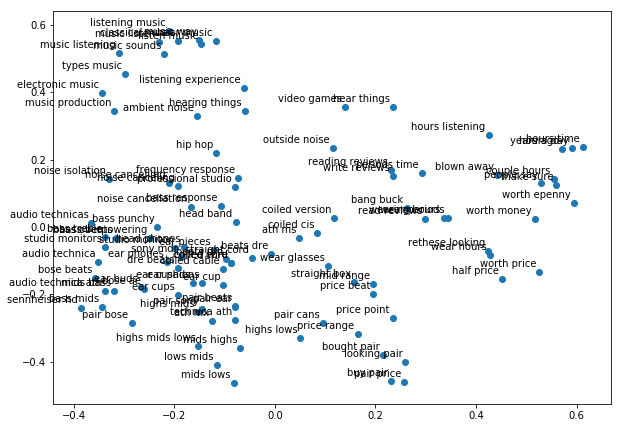

In [27]:
import matplotlib.pyplot as plt

labels = terms 
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(X2[:,0],X2[:,1], label='True Position')

for label, x, y in zip(labels, X2[:, 0], X2[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

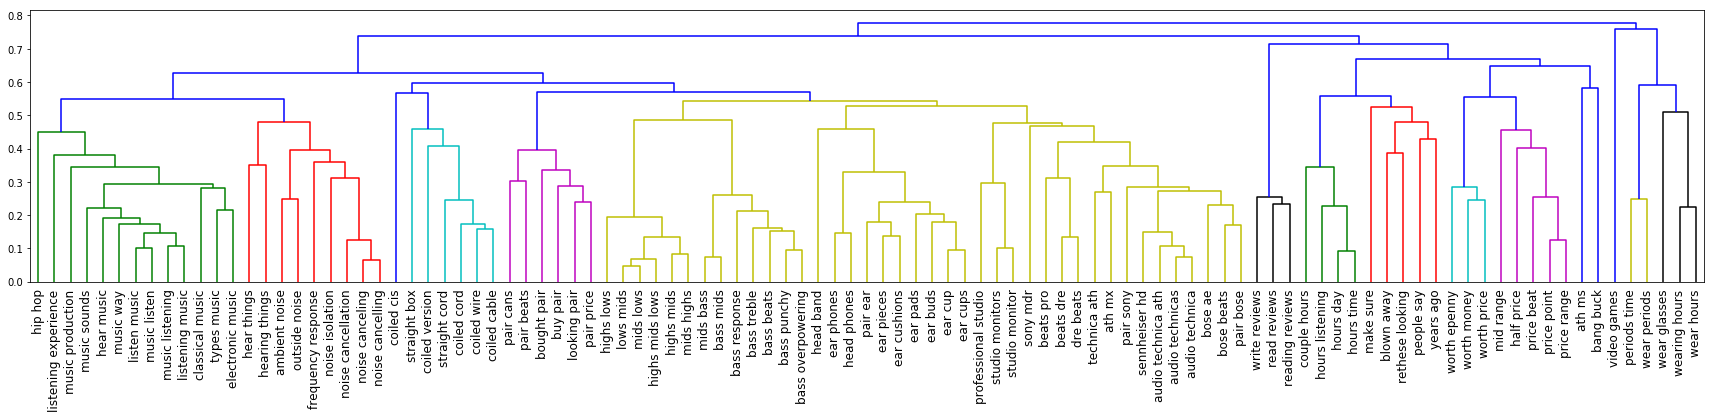

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist

#dist_condensed = pdist(X)
#linked = linkage(X, 'single',metric='cosine',optimal_ordering=True)
linked = linkage(X, 'average', metric='cosine',optimal_ordering=True)
labelList = terms

plt.figure(figsize=(30, 5))  
dh = dendrogram(linked,  
            orientation='top',
            labels=labelList,
            leaf_font_size=12,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [29]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.2.


In [30]:
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline
import numpy as np  
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold =0.45)  
term_clusters = cluster.fit_predict(X)  
term_clusters

array([ 0,  2,  7,  0, 21,  2,  3,  2,  6, 20,  8,  8, 16, 20,  7, 24, 22,
        6,  0,  0,  8, 27, 15,  2, 14,  8,  4,  2,  9, 22,  5,  5,  0, 17,
        6,  6, 25, 11, 20,  5,  1, 10, 14, 13, 11, 13,  3, 20,  0,  0,  3,
       18,  7,  8,  5,  2, 17, 17, 14,  8,  0, 19,  3,  0,  2,  2, 10,  6,
        2, 17,  2, 17,  0, 17,  1,  5,  3, 16,  8,  6, 13,  2, 26, 12,  0,
       13, 22,  7,  6,  0,  4, 20,  2, 23,  8, 20,  5,  8, 17,  2,  0, 11,
        9], dtype=int64)

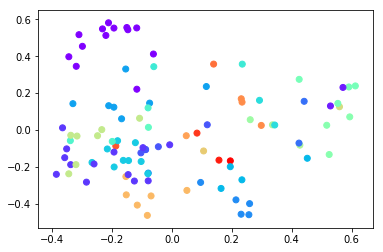

In [31]:
plt.scatter(X2[:,0],X2[:,1], c=cluster.labels_, cmap='rainbow') 

In [32]:
cluster_numbers = np.amax(term_clusters)
print('Number of keyword clusters:',cluster_numbers)

Number of keyword clusters: 27


In [33]:
cluster_data = {'term':terms, 'cluster':term_clusters}
df_cluster = pd.DataFrame(cluster_data)

In [34]:
df_cluster.to_csv("output/ATH_headphone_keywords.csv",index=False)
####### load
df_cluster = pd.read_csv("output/ATH_headphone_keywords.csv")
cluster_numbers = np.amax(df_cluster.cluster.tolist())

In [35]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    df_cluster['embedding'] = pd.Series(list(session.run(embed(list(df_cluster['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 23:10:27.623314  7704 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 4.674312114715576


In [36]:
df_cluster.head()

,term,cluster,embedding
0,listening music,0,"[-0.045451768, -0.04760361, -0.034584887, 0.04..."
1,audio technica,2,"[0.06332447, 0.015068867, -0.042115867, 0.0494..."
2,price range,7,"[0.041651044, 0.0057591093, -0.047061507, 0.06..."
3,listen music,0,"[-0.046671312, -0.043211374, -0.012437216, 0.0..."
4,ath ms,21,"[0.008852492, 0.061217256, -0.039080944, 0.006..."


In [37]:
group = []
emb_group = []
for i in range(cluster_numbers+1):
    terms_in_group = df_cluster.loc[df_cluster['cluster']==i]['term'].tolist()
    embs_in_group = df_cluster.loc[df_cluster['cluster']==i]['embedding'].tolist()
    if len(terms_in_group)>=3:
        group.append(terms_in_group)
        emb_group.append(embs_in_group)
        print('Group '+str(i)+':\n',terms_in_group,'\n')

Group 0:
 ['listening music', 'listen music', 'hear music', 'hip hop', 'music listening', 'listening experience', 'classical music', 'electronic music', 'music listen', 'music sounds', 'music production', 'types music', 'music way'] 

Group 2:
 ['audio technica', 'beats dre', 'sennheiser hd', 'technica ath', 'audio technica ath', 'dre beats', 'bose ae', 'pair bose', 'bose beats', 'audio technicas', 'beats pro', 'ath mx', 'pair sony'] 

Group 3:
 ['coiled cord', 'coiled version', 'coiled cable', 'straight cord', 'coiled wire'] 

Group 5:
 ['looking pair', 'pair beats', 'buy pair', 'bought pair', 'pair price', 'pair cans'] 

Group 6:
 ['noise cancelling', 'noise canceling', 'noise cancellation', 'frequency response', 'noise isolation', 'outside noise', 'ambient noise'] 

Group 7:
 ['price range', 'price point', 'half price', 'price beat'] 

Group 8:
 ['ear pads', 'ear cups', 'head phones', 'ear buds', 'ear phones', 'ear pieces', 'ear cushions', 'ear cup', 'pair ear'] 

Group 11:
 ['studi

In [38]:
avg_embs = []

for embs in emb_group:
    temp_avg = np.zeros(len(embs[0]))
    for term_emb1 in embs:
        temp_avg = temp_avg+term_emb1
        term_avg = temp_avg/len(embs)
    avg_embs.append(term_avg)

In [39]:
data2 = {'terms':group, 'avg_emb':avg_embs}
cluster_embs = pd.DataFrame(data2)
cluster_embs

,terms,avg_emb
0,"[listening music, listen music, hear music, hi...","[-0.02844456905642381, -0.03165019464750703, -..."
1,"[audio technica, beats dre, sennheiser hd, tec...","[0.06266361761551636, 0.009346599090629472, -0..."
2,"[coiled cord, coiled version, coiled cable, st...","[0.04198226258158684, 0.028864430263638496, -0..."
3,"[looking pair, pair beats, buy pair, bought pa...","[-0.018104390085985262, -0.013731722875187794,..."
4,"[noise cancelling, noise canceling, noise canc...","[0.028526609231318747, 0.02375163876318506, -0..."
5,"[price range, price point, half price, price b...","[0.018818118143826723, 0.021023027482442558, -..."
6,"[ear pads, ear cups, head phones, ear buds, ea...","[0.01814197428838169, 0.05074190658827623, -0...."
7,"[studio monitor, studio monitors, professional...","[0.01475410225490729, -0.016316844150424004, -..."
8,"[hours day, hours time, hours listening, coupl...","[-0.06253418978303671, 0.04093605140224099, -0..."
9,"[worth money, worth epenny, worth price]","[0.03107421783109506, 0.004528017404178779, -0..."


In [40]:
import pickle
pickle.dump(cluster_embs, open("output/ATH_headphone_embs.pickle", "wb"))

In [41]:
test_load = pickle.load(open("output/ATH_headphone_embs.pickle", "rb"))
test_load

,terms,avg_emb
0,"[listening music, listen music, hear music, hi...","[-0.02844456905642381, -0.03165019464750703, -..."
1,"[audio technica, beats dre, sennheiser hd, tec...","[0.06266361761551636, 0.009346599090629472, -0..."
2,"[coiled cord, coiled version, coiled cable, st...","[0.04198226258158684, 0.028864430263638496, -0..."
3,"[looking pair, pair beats, buy pair, bought pa...","[-0.018104390085985262, -0.013731722875187794,..."
4,"[noise cancelling, noise canceling, noise canc...","[0.028526609231318747, 0.02375163876318506, -0..."
5,"[price range, price point, half price, price b...","[0.018818118143826723, 0.021023027482442558, -..."
6,"[ear pads, ear cups, head phones, ear buds, ea...","[0.01814197428838169, 0.05074190658827623, -0...."
7,"[studio monitor, studio monitors, professional...","[0.01475410225490729, -0.016316844150424004, -..."
8,"[hours day, hours time, hours listening, coupl...","[-0.06253418978303671, 0.04093605140224099, -0..."
9,"[worth money, worth epenny, worth price]","[0.03107421783109506, 0.004528017404178779, -0..."


In [42]:
cluster_centers = test_load['avg_emb'].tolist()
cluster_centers_labels = test_load['terms'].tolist()

In [43]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'Audio-Technica ATH Professional Studio Monitor Headphones'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [44]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    reviews['embedding'] = pd.Series(list(session.run(embed(list(reviews['text'])))))
reviews.head()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 23:11:29.771200  7704 saver.py:1483] Saver not created because there are no variables in the graph to restore


,text,embedding
0,great headphones except it hurts my head after...,"[0.023935653, 0.0034492523, -0.0056872102, 0.0..."
1,"Because of the sound cancellation, I'd find my...","[-0.010593622, 0.055789355, 0.030662157, -0.03..."
2,Was a little too tight for me though,"[0.025174437, -0.011178963, -0.012607803, -0.0..."
3,Fantastic sound quality and got here pretty qu...,"[-0.009091104, -0.046820533, -0.00013145777, -..."
4,Do not hesitate to order these,"[-0.014508884, -0.04255618, -0.013950949, 0.01..."


In [45]:
def find_closest(centers, text_emb):
    distances = np.inner(centers,text_emb)
    if np.amax(distances)<=0.5:
        return -1
    else:
        return np.where(distances == np.amax(distances))[0][0]

In [46]:
reviews['cluster'] = reviews['embedding'].apply(lambda x: find_closest(cluster_centers,x))
reviews

,text,embedding,cluster
0,great headphones except it hurts my head after...,"[0.023935653, 0.0034492523, -0.0056872102, 0.0...",6
1,"Because of the sound cancellation, I'd find my...","[-0.010593622, 0.055789355, 0.030662157, -0.03...",4
2,Was a little too tight for me though,"[0.025174437, -0.011178963, -0.012607803, -0.0...",-1
3,Fantastic sound quality and got here pretty qu...,"[-0.009091104, -0.046820533, -0.00013145777, -...",-1
4,Do not hesitate to order these,"[-0.014508884, -0.04255618, -0.013950949, 0.01...",3
5,Great sound and comfortable to boot,"[0.063125364, -0.06527017, -0.029320424, 0.024...",-1
6,I use them for everything from mp3 headphones ...,"[0.01967602, 0.058391973, -0.014327442, -0.009...",1
7,Seriously worth it and doubly so if they're on...,"[-0.027947301, 0.07377788, -0.047472607, -0.01...",-1
8,I've used these headphones for a year and a ha...,"[0.047727227, -0.00696438, -0.024244735, 0.000...",1
9,They are also comfortable on your ears and do ...,"[0.060537763, 0.061116703, -0.010659479, 0.010...",6


In [47]:
len1 = len(cluster_centers)
clustered_sentences = []
for i in range(len1):
    s1 = reviews.loc[reviews['cluster']==i,['text']]['text'].tolist()
    print('cluster',i,'----  contents:',cluster_centers_labels[i],'\n')
    print(s1)
    print('\n\n')
    temp_str = ''
    for j in range(len(s1)):
        temp_str = temp_str + s1[j] + '. '
    clustered_sentences.append(temp_str)

cluster 0 ----  contents: ['listening music', 'listen music', 'hear music', 'hip hop', 'music listening', 'listening experience', 'classical music', 'electronic music', 'music listen', 'music sounds', 'music production', 'types music', 'music way'] 

['I have honestly missed out on the beauty of music for so long', 'Music Standard : Metal, Heavy Metal, Death MetalGaming Standard : First Person Shooters, Real-Time StrategyMusic Notes : I have an extremely high standard when it comes to music and those who love the craft will argue their views into the ground', 'An example would be the during the song &#34;You Already Know What You Are&#34; by A Day to Remember at ~0:54', 'Really makes you focus on the music', 'clear sound good bass, mostly use them on my lap top listing to music', 'I listen to a lot of jazz piano trio, classical, movie themes, piano solo, that can accurately reproduce brass, bass, and percussion', "These headphones allow me to hear new detail in songs I've been listenin

cluster 2 ----  contents: ['coiled cord', 'coiled version', 'coiled cable', 'straight cord', 'coiled wire'] 

['I suggest getting the coiled cable and not the straight one', 'You should purchase the version with DETACHABLE CABLE', 'The cable is very long and heavy, and high quality, I highly recommend the version with the coiled and removable cable', 'I opted for the stretchy cord instead of the lengthy solid cord and I am glad', 'Spring on cord protects against flex damage', "There is one or two cons; I ordered the straight cord instead of the coiled, which was a bad decision on my part, because you're lugging around a 10 foot cord", 'My only concern is that the ATH-M50 does not have a removable cord, so if the wire were to break or snap, I would have to replace the whole set', 'Telephone style cable and 1/4 & 1/8 inch adapters are a huge bonus', "The cable is very thick and high quality, and the 1/4'' adapter screws on to make it seem like a native 1/4'' cable when you use it", '- Th

In [48]:
pickle.dump(clustered_sentences, open("output/ATH_headphones_sentences.pickle", "wb"))